---
### Imports

In [1]:
import pandas as pd
import torch
from torchmetrics import Accuracy, F1Score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from tqdm import tqdm

W0618 19:14:27.736000 19336 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


---
### Load Dataset
##### Train:

In [2]:
data_frame_train = pd.read_csv('./dataset/train.csv')
x = data_frame_train.drop('price_range', axis=1)
y = data_frame_train['price_range']

In [3]:
x

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1


In [4]:
y

0       1
1       2
2       2
3       2
4       1
       ..
1995    0
1996    2
1997    3
1998    0
1999    3
Name: price_range, Length: 2000, dtype: int64

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, random_state=42)

In [6]:
x_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
836,902,1,0.6,1,0,0,63,0.7,122,5,14,364,1360,3654,18,8,15,0,1,1
575,1197,1,0.5,1,9,0,20,0.1,129,5,10,214,1710,2885,19,7,14,1,1,1
557,1519,0,2.1,0,0,0,32,0.7,200,1,10,168,1239,2912,11,10,15,1,1,0
1235,1971,1,0.5,1,0,0,40,0.3,186,7,19,485,922,571,8,7,17,1,1,0
1360,882,0,0.7,1,9,1,28,0.2,151,6,16,248,884,751,19,11,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1975,1,1.9,1,2,0,31,0.9,151,1,17,775,1607,3022,13,5,19,0,0,1
1294,589,1,0.5,0,1,1,59,0.7,146,8,4,759,1858,362,16,10,6,1,1,1
860,1829,1,0.5,0,0,1,15,0.4,160,5,7,729,1267,2080,16,11,12,1,0,1
1459,1927,0,0.9,1,3,0,11,0.4,190,8,12,491,1506,2916,16,11,18,0,1,1


---
### Preprocessing

In [7]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

In [8]:
x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

---
### Normalization (Standardization)

In [9]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

---
### Dataloader

In [10]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=600, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=800, shuffle=False)

---
### Define Model

In [11]:
num_feats = 20
out_feats = 4
h1 = 64
h2 = 32

model = torch.nn.Sequential(torch.nn.Linear(num_feats, h1),
                            torch.nn.ReLU(),
                            # torch.nn.Dropout(0.5),
                            torch.nn.Linear(h1, h2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(h2, out_feats))
model

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)

---
### Device

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
device

'cuda'

---
### Loss Function

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

---
### Optimizer

In [14]:
optim_names = ['sgd', 'rms', 'adam']

In [15]:
# optim_name = optim_names[0]
# optimizer = torch.optim.SGD(model.parameters(),
#                             lr=0.001,
#                             momentum=0.9,
#                             nesterov=True,
#                             weight_decay=1e-4)

# optim_name = optim_names[1]
# optimizer = torch.optim.RMSprop(model.parameters(),
#                                 lr=0.001,
#                                 alpha=0.99)

optim_name = optim_names[2]
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999))

---
### AverageMeter

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

---
### Methods of train and validate model:

In [17]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=4).to(device)
    f1_train = F1Score(task="multiclass", num_classes=4).to(device)

    with tqdm(train_loader, unit='batch') as t_loader:
        for data, target in t_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict.squeeze(), target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(predict, target)
            f1_train(predict, target)

            t_loader.set_description(f"Epoch: {epoch}")
            t_loader.set_postfix(loss=loss_train.avg,
                                 accuracy=f"{(acc_train.compute().cpu().item() * 100):.4}%",
                                 f1=f"{(f1_train.compute().cpu().item() * 100):.4}%")

    return model, loss_train.avg, acc_train.compute(), f1_train.compute()

In [18]:
def valid_one_epoch(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes=4).to(device)
        f1_valid = F1Score(task="multiclass", num_classes=4).to(device)
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)

            predict = model(data)
            loss = loss_fn(predict.squeeze(), target)

            loss_valid.update(loss.item())
            acc_valid(predict, target)
            f1_valid(predict, target)

    return loss_valid.avg, acc_valid.compute(), f1_valid.compute()


---
### Train

In [19]:
epochs = 300

In [20]:
hist_loss_train = []
hist_loss_valid = []

hist_acc_train = []
hist_acc_valid = []

hist_f1_train = []
hist_f1_valid = []

In [ ]:
for epoch in range(epochs):
    model, loss_train, acc_train, f1_train = train_one_epoch(model=model,
                                                             train_loader=train_loader,
                                                             loss_fn=loss_fn,
                                                             optimizer=optimizer,
                                                             epoch=epoch)

    loss_valid, acc_valid, f1_valid = valid_one_epoch(model=model, valid_loader=valid_loader, loss_fn=loss_fn)

    hist_loss_train.append(loss_train)
    hist_loss_valid.append(loss_valid)

    hist_acc_train.append(acc_train.cpu())
    hist_acc_valid.append(acc_valid.cpu())

    hist_f1_train.append(f1_train.cpu())
    hist_f1_valid.append(f1_valid.cpu())

    print(f"Loss_valid: {loss_valid:.4}, Accuracy_valid: {(acc_valid * 100):.4}%, F1_valid: {(f1_valid * 100):.4}%")

---
### Plot (Loss)

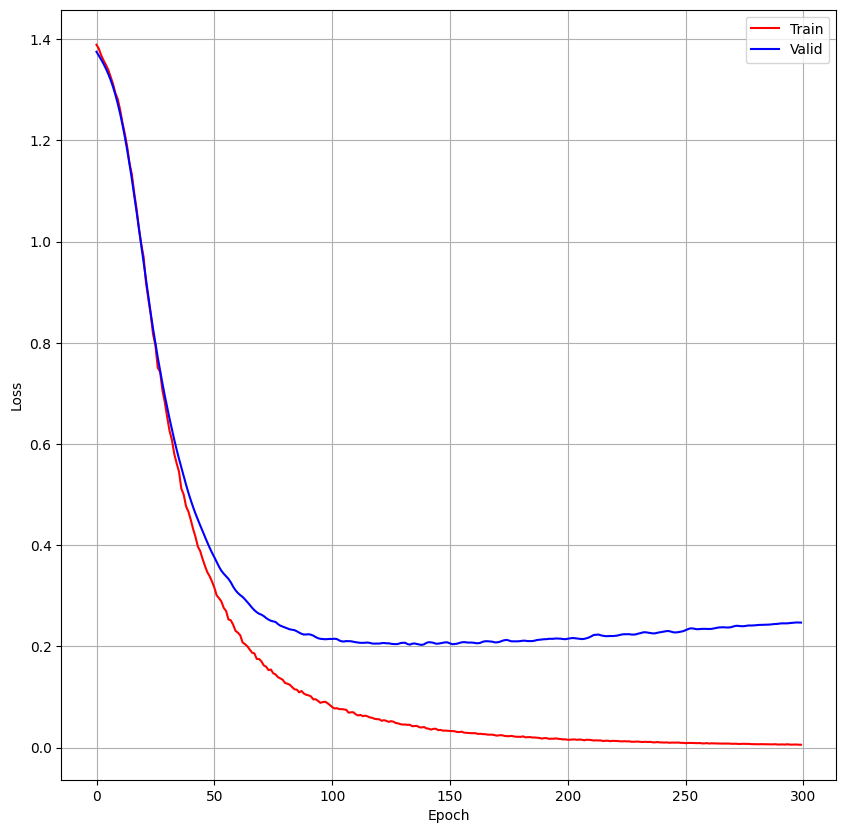

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_loss_train, 'r-', label='Train')
ax.plot(range(epochs), hist_loss_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.legend()

###  Plot (Accuracy)

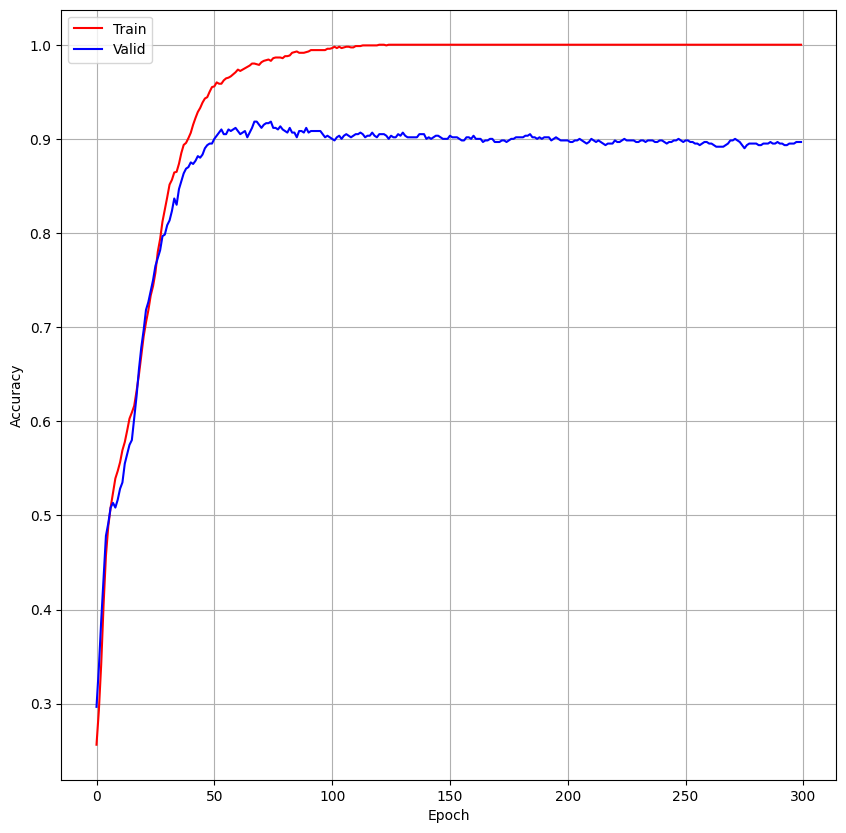

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_acc_train, 'r-', label='Train')
ax.plot(range(epochs), hist_acc_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.grid(True)
ax.legend()

#### Plot (F1 Score)

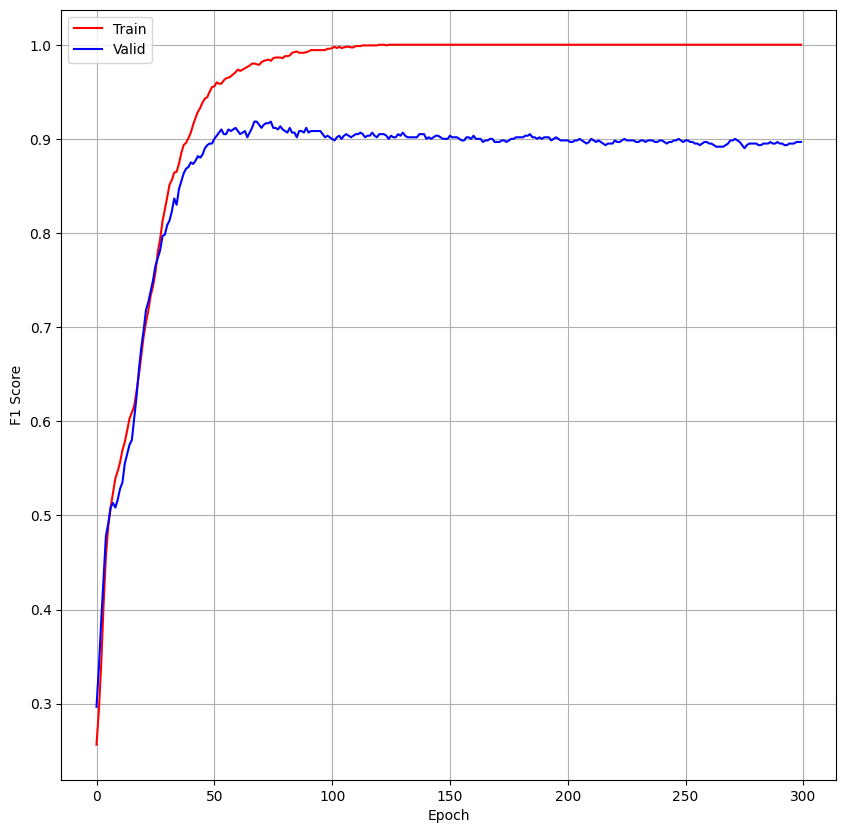

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(epochs), hist_f1_train, 'r-', label='Train')
ax.plot(range(epochs), hist_f1_valid, 'b-', label='Valid')

ax.set_xlabel('Epoch')
ax.set_ylabel('F1 Score')
ax.grid(True)
ax.legend()

---
### Save Model

In [88]:
!mkdir save

A subdirectory or file save already exists.


In [89]:
# torch.save(model, './save/model.pt')

torch.save(torch.tensor(hist_acc_train), f'./save/{optim_name}_acc_train.pt')
torch.save(torch.tensor(hist_acc_valid), f'./save/{optim_name}_acc_valid.pt')

torch.save(torch.tensor(hist_loss_train), f'./save/{optim_name}_loss_train.pt')
torch.save(torch.tensor(hist_loss_valid), f'./save/{optim_name}_loss_valid.pt')

In [90]:
# torch.load('./save/model.pt', weights_only=False)

---
#### Comparing

In [21]:
def plot_lcs(x: str = 'loss' or 'acc', y: str = 'train' or 'valid'):
    plt.figure(figsize=(8, 6))
    for name in optim_names:
        z = torch.load(f'./save/{name}_{x}_{y}.pt')
        plt.plot(range(epochs), z, label=name)
        plt.xlabel('Epoch')
        plt.ylabel(f'{x}-{y}')
        plt.grid(True)
        plt.legend()

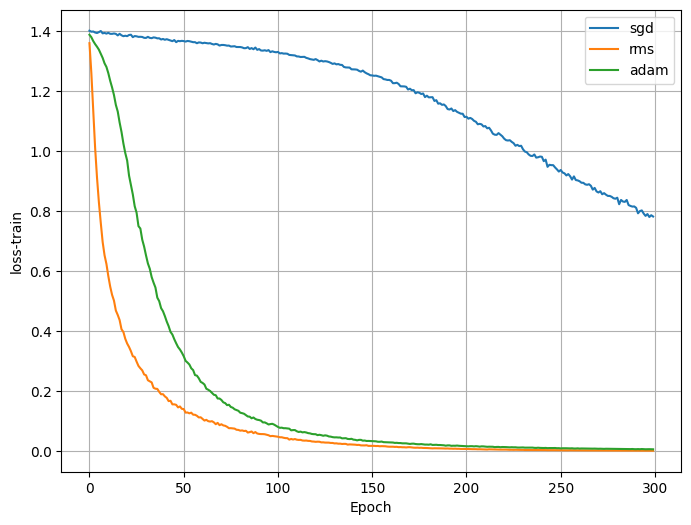

In [22]:
plot_lcs(x='loss', y='train')

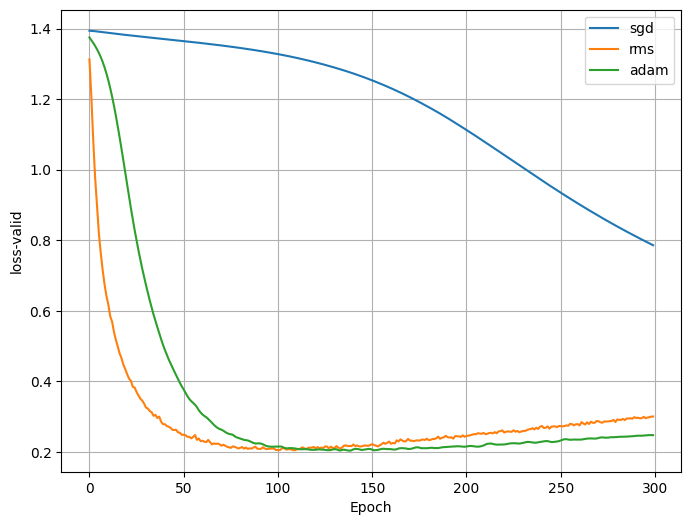

In [23]:
plot_lcs(x='loss', y='valid')

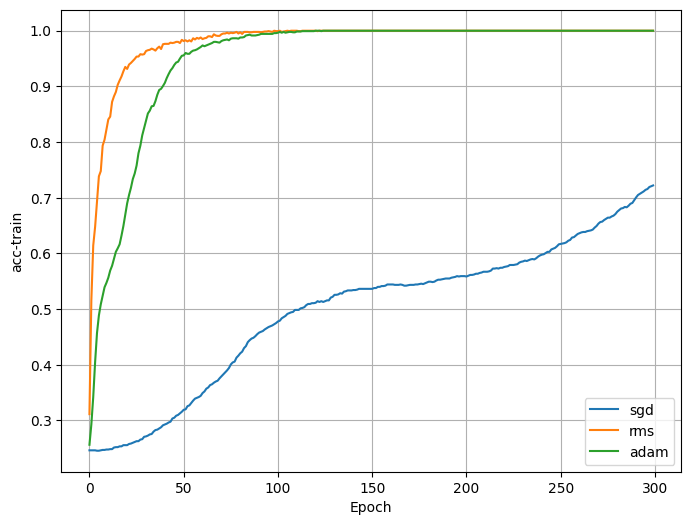

In [26]:
plot_lcs(x='acc', y='train')

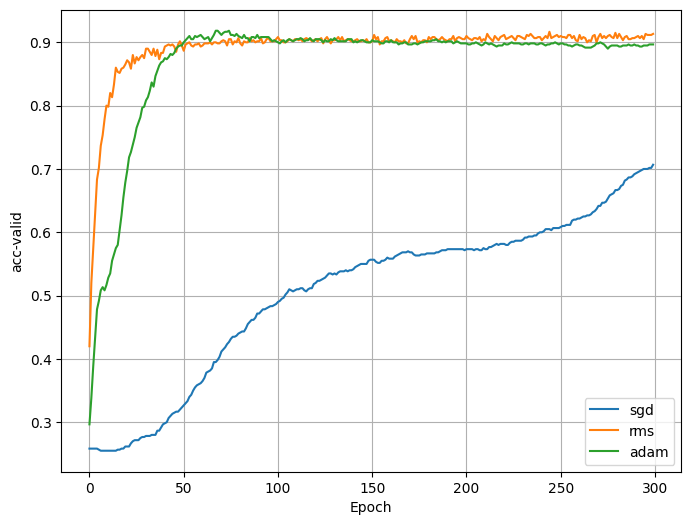

In [27]:
plot_lcs(x='acc', y='valid')